In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

!unzip '/content/drive/MyDrive/Colab Notebooks/GeneralDS/data/oxfords_flowers.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/GeneralDS/data/oxfords_flowers.zip
  inflating: oxfords_flowers_test.bin  
  inflating: oxfords_flowers_train.bin  
  inflating: oxfords_flowers_valid.bin  


In [3]:
import numpy as np
import pandas as pd

In [4]:
def read_data(file_path):
    with open(file_path, 'rb') as f:

        header = np.fromfile(f, dtype=np.uint32, count=4)
        num_samples, rows, columns, num_channels = header

        X = np.fromfile(f, dtype=np.uint8, count=num_samples * rows * columns * num_channels)
        X = X.reshape(num_samples, rows, columns, num_channels)

        Y = np.fromfile(f, dtype=np.uint8)
        return X, Y

x_train, y_train = read_data('oxfords_flowers_train.bin')
x_valid, y_valid = read_data('oxfords_flowers_valid.bin')
x_test,  y_test  = read_data('oxfords_flowers_test.bin')

The classes starts from 1 to 102, But the result of the last layer in fully connected neural network starts from 0. So we should decreament from them

In [5]:
y_train = y_train - 1
y_valid = y_valid - 1
y_test  = y_test  - 1

### Dimensional reduction



PCA just accepts the dimentional lower or equall than 2, So we need convert every 100*100*3 image pixels into a 30000 flatten array

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(0.95)

x_train_f = x_train.reshape(x_train.shape[0], -1)

pca.fit(x_train_f)

PCA(n_components=0.95)

Text(0, 0.5, 'Explained variance')

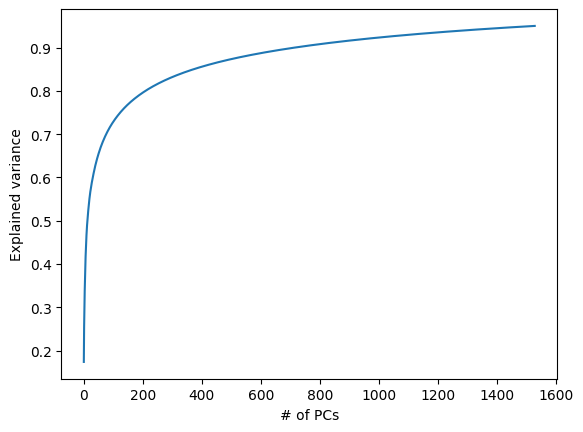

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("# of PCs")
plt.ylabel("Explained variance")

In [ ]:
x_train_pca = pca.transform(x_train.reshape(x_train.shape[0], -1))
x_valid_pca = pca.transform(x_valid.reshape(x_valid.shape[0], -1))
x_test_pca = pca.transform(x_test.reshape(x_test.shape[0], -1))

print(x_train_pca.shape)

(6149, 1529)


In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Softmax, Dropout, Flatten
from tensorflow.keras.activations import relu, sigmoid, tanh
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2

model = Sequential()

model.add(Dense(x_train_pca.shape[1], activation=relu, kernel_regularizer=l2(1e-1), bias_regularizer=l2(1e-1), input_shape=(x_train_pca.shape[1],)))
# model.add(Flatten(input_shape=(x_train_pca.shape[1],)))

model.add(Dense(500, activation=relu, kernel_regularizer=l2(1e-1), bias_regularizer=l2(1e-1)))
model.add(Dropout(0.2))
model.add(Dense(500, activation=relu, kernel_regularizer=l2(1e-1), bias_regularizer=l2(1e-1)))
model.add(Dropout(0.2))
model.add(Dense(500, activation=relu, kernel_regularizer=l2(1e-1), bias_regularizer=l2(1e-1)))
model.add(Dropout(0.2))
model.add(Dense(500, activation=relu, kernel_regularizer=l2(1e-1), bias_regularizer=l2(1e-1)))
model.add(Dropout(0.2))
model.add(Dense(500, activation=relu, kernel_regularizer=l2(1e-1), bias_regularizer=l2(1e-1)))
model.add(Dropout(0.2))

model.add(Dense(102, activation='sigmoid', kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4)))
model.build()
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 1529)              2339370   
                                                                 
 dense_44 (Dense)            (None, 500)               765000    
                                                                 
 dropout_30 (Dropout)        (None, 500)               0         
                                                                 
 dense_45 (Dense)            (None, 500)               250500    
                                                                 
 dropout_31 (Dropout)        (None, 500)               0         
                                                                 
 dense_46 (Dense)            (None, 500)               250500    
                                                                 
 dropout_32 (Dropout)        (None, 500)             

In [ ]:
model.compile(optimizer=Adam(learning_rate = 0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = 32
earlyStop = EarlyStopping(monitor='val_loss', patience=early_stop, verbose=1, mode='auto')

check_point_name = 'best_weight.hdf5'
check_point = ModelCheckpoint(filepath = check_point_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train_pca, y_train,
                    batch_size=32,
                    epochs=150,
                    verbose=1,
                    validation_data=(x_valid_pca, y_valid),
                    callbacks=[earlyStop, check_point],
                    shuffle=True)

Epoch 1/150
185/193 [===========================>..] - ETA: 0s - loss: 469.9613 - accuracy: 0.0169
Epoch 1: val_loss improved from inf to 420.04202, saving model to best_weight.hdf5
193/193 [==============================] - 4s 9ms/step - loss: 468.4533 - accuracy: 0.0169 - val_loss: 420.0420 - val_accuracy: 0.0186
...
Epoch 75/150
186/193 [===========================>..] - ETA: 0s - loss: 3.1467 - accuracy: 0.5565
Epoch 75: val_loss did not improve from 4.31364
193/193 [==============================] - 1s 7ms/step - loss: 3.1502 - accuracy: 0.5554 - val_loss: 5.6822 - val_accuracy: 0.1373
Epoch 75: early stopping


As you can see, the first model with PCA of 95% accuracy has 52% accuracy in training data and 12% in validation data `at the same time`
So the early stoping cuts the training process. next we try `Data Agmentation` like flipping images or shifting into four direction to decrease the rate of Overfit

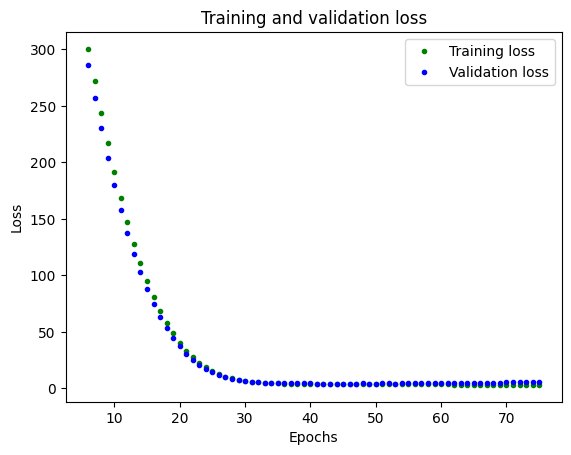

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
SKIP = 5
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

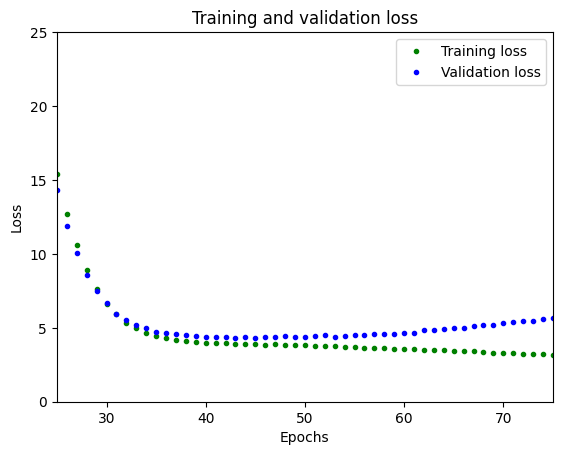

In [ ]:
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 25)
plt.xlim(25, 75)
plt.show()

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(rotation_range=90,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant')

train_generator = data_generator.flow(x_train, y_train, batch_size=1)
valid_generator = data_generator.flow(x_valid, y_valid, batch_size=1)

In [25]:
from keras import regularizers

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.regularizers import l2

model = Sequential()

# kernels

model.add(Conv2D(filters=32, kernel_size=3, kernel_regularizer=l2(1e-2), bias_regularizer=l2(1e-2), strides=1, input_shape=(100, 100, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=3, kernel_regularizer=l2(1e-2), bias_regularizer=l2(1e-2), strides=1))
model.add(Activation('relu'))
model.add(Conv2D(filters=64, kernel_size=3, kernel_regularizer=l2(1e-2), bias_regularizer=l2(1e-2), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=3, kernel_regularizer=l2(1e-2), bias_regularizer=l2(1e-2), strides=1))
model.add(Activation('relu'))
model.add(Conv2D(filters=128, kernel_size=3, kernel_regularizer=l2(1e-2), bias_regularizer=l2(1e-2), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.01))

# fully connected

model.add(Flatten())
# 450
# model.add(Dense(370, activation=relu))
model.add(Dense(1500, activation=relu, kernel_regularizer=l2(1e-2), bias_regularizer=l2(1e-2)))
model.add(Dropout(0.01))
# model.add(Dense(1000, activation=relu, kernel_regularizer=l2(1e-2), bias_regularizer=l2(1e-2)))
# model.add(Dropout(0.01))
# model.add(Dense(500, activation=relu, kernel_regularizer=l2(1e-1), bias_regularizer=l2(1e-1)))
# model.add(Dropout(0.5))

model.add(Dense(102, activation='softmax', kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4)))
model.build()
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 activation_27 (Activation)  (None, 98, 98, 32)        0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 49, 49, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 activation_28 (Activation)  (None, 47, 47, 64)        0         
                                                                 
 conv2d_29 (Conv2D)          (None, 45, 45, 64)        36928     
                                                      

In [21]:
# model.compile(optimizer=Adam(learning_rate = 0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# tf.keras.losses.MeanSquaredError
# early_stop = 32
# earlyStop = EarlyStopping(monitor='val_loss', patience=early_stop, verbose=1, mode='auto')

# check_point_name = 'best_weight.hdf5'
# check_point = ModelCheckpoint(filepath = check_point_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# history = model.fit(x_train, y_train,
#                     epochs=400,
#                     verbose=1,
#                     validation_data=(x_valid, y_valid),
#                     callbacks=[earlyStop, check_point],
#                     shuffle=True)

In [26]:
model.compile(optimizer=Adam(learning_rate = 0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tf.keras.losses.MeanSquaredError
early_stop = 32
earlyStop = EarlyStopping(monitor='val_loss', patience=early_stop, verbose=1, mode='auto')

check_point_name = 'best_weight.hdf5'
check_point = ModelCheckpoint(filepath = check_point_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit_generator(train_generator,
                              epochs=100,
                              verbose=1,
                              validation_data=valid_generator,
                              callbacks=[earlyStop, check_point],
                              shuffle=True)

Epoch 1/100


<ipython-input-26-c8a211f6ae37>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


6143/6149 [============================>.] - ETA: 0s - loss: 11.5675 - accuracy: 0.0972
Epoch 1: val_loss improved from inf to 5.40273, saving model to best_weight.hdf5
...
Epoch 100: val_loss did not improve from 2.61079
6149/6149 [==============================] - 71s 12ms/step - loss: 2.1927 - accuracy: 0.5920 - val_loss: 2.7906 - val_accuracy: 0.4676


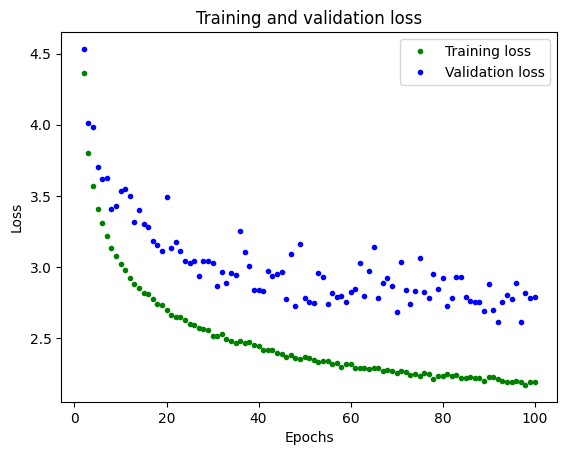

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
SKIP = 1
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [1]:
y_pred_1 = model.predict(x_test)
y_pred = []
for record in range(len(x_test)):
  y_pred.append(y_pred_1[record].argmax()+1)

y_pred = np.array(y_pred)

from sklearn.metrics import multilabel_confusion_matrix
y_unique = np.arange(1, 103)
mcm = multilabel_confusion_matrix(y_test, y_pred, labels = y_unique)
mcm